# Kaggle Spooky Author Identification Entry

**Name**: George-Bogdan Ivanov
**Contact**: human@nlpforhackers.io
**Website**: http://nlpforhackers.io



In [41]:
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.base import TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Perceptron, PassiveAggressiveClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.neighbors import NearestCentroid, KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, BaggingClassifier
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder, LabelBinarizer

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.collocations import *
from nltk import RegexpParser
from nltk import Tree
from nltk import Text
from nltk import bigrams, trigrams

import matplotlib.pyplot as plt

## Load Data

In [3]:
df = pd.read_csv('data/train.csv')
text, author = df['text'], df['author']
X_train, X_test, y_train, y_test = train_test_split(text, author, test_size=0.2, shuffle=True)


## First simple attempt

In [6]:
p1 = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=word_tokenize)),
    ('classifier', LogisticRegression()),
])

p1.fit(X_train, y_train)
print(p1.score(X_test, y_test))

0.835035750766


In [7]:
p2 = Pipeline([
    ('vectorizer', CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)),
    ('classifier', LogisticRegression()),
])

p2.fit(X_train, y_train)
print(p2.score(X_test, y_test))

0.83835546476


In [ ]:
# p5 = Pipeline([
#     ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
#     ('classifier', LogisticRegression()),
# ])

# p5.fit(X_train, y_train)
# print(p5.score(X_test, y_test))

In [ ]:
# p3 = Pipeline([
#     ('vectorizer', CountVectorizer(ngram_range=(1, 3))),
#     ('classifier', LogisticRegression()),
# ])

# p3.fit(X_train, y_train)
# print(p3.score(X_test, y_test))

## Try a different tokenizer

In [ ]:
# p5 = Pipeline([
#     ('vectorizer', CountVectorizer(
#         ngram_range=(1, 2), tokenizer=word_tokenize)),
#     ('classifier', LogisticRegression()),
# ])

# p5.fit(X_train, y_train)
# print(p5.score(X_test, y_test))

## Feature Engineering

### Sentence Length

In [8]:
from collections import defaultdict
from nltk import sent_tokenize, word_tokenize

classes = set(y_train)
sentence_word_count = defaultdict(lambda: 0)
sentence_count = defaultdict(lambda: 0)
sentence_dist = {a: defaultdict(lambda: 0) for a in classes}

for author in classes:
    author_df = df[df['author'] == author]
    idx = 1
    for _, row in author_df.iterrows():
        if idx % 1000 == 0:
            print("%s/%s texts processed" % (idx, len(author_df)))
        sentences = sent_tokenize(row['text'])
        sentence_count[author] += len(sentences)
        for s in sentences:
            words = word_tokenize(s)
            sentence_word_count[author] += len(words)
            sentence_dist[author][len(words)] += 1
        idx += 1
    print("Finished for author %s\n" % author)

mean_sentence_word_count = {a: sentence_word_count[a] / sentence_count[a] for a in classes}
print(mean_sentence_word_count)

1000/6044 texts processed
2000/6044 texts processed
3000/6044 texts processed
4000/6044 texts processed
5000/6044 texts processed
6000/6044 texts processed
Finished for author MWS

1000/7900 texts processed
2000/7900 texts processed
3000/7900 texts processed
4000/7900 texts processed
5000/7900 texts processed
6000/7900 texts processed
7000/7900 texts processed
Finished for author EAP

1000/5635 texts processed
2000/5635 texts processed
3000/5635 texts processed
4000/5635 texts processed
5000/5635 texts processed
Finished for author HPL

{'MWS': 30.81331592689295, 'EAP': 28.29441871801121, 'HPL': 29.608407079646017}


AUTHOR:  MWS


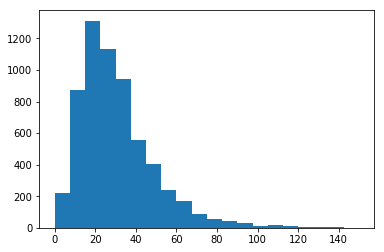

AUTHOR:  EAP


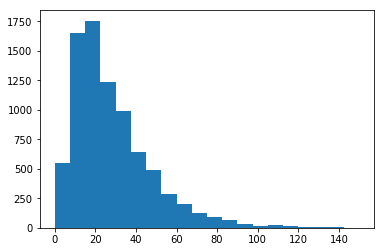

AUTHOR:  HPL


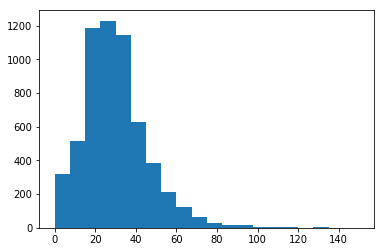

In [9]:
def iter_df_sent_word_count(df):
    for _, row in df.iterrows():
        sentences = sent_tokenize(row['text'])
        for s in sentences:
            words = word_tokenize(s)
            yield len(words)

for author in classes:
    print("AUTHOR: ", author)
    author_df = df[df['author'] == author]
    plt.hist(list(iter_df_sent_word_count(author_df)), bins=20, range=(0, 150))
    plt.show()

## Adjectives/Adverbs per sentence

In [10]:
from collections import defaultdict
from nltk import sent_tokenize, word_tokenize, pos_tag

classes = set(y_train)
sentence_count = defaultdict(lambda: 0)
sentence_adjadv_percent = defaultdict(lambda: 0)


for author in classes:
    author_df = df[df['author'] == author]
    idx = 1
    for _, row in author_df.iterrows():
        if idx % 1000 == 0:
            print("%s/%s texts processed" % (idx, len(author_df)))
        sentences = sent_tokenize(row['text'])
        sentence_count[author] += len(sentences)
        for s in sentences:
            words = word_tokenize(s)
            adjadv = len([w for w, t in pos_tag(words) if t.startswith("RB") or t.startswith("JJ")])
            sentence_adjadv_percent[author] += adjadv / len(words)
        idx += 1
    print("Finished for author %s\n" % author)

mean_sentence_word_count = {sentence_adjadv_percent[a] / sentence_count[a] for a in classes}
print(mean_sentence_word_count)

1000/6044 texts processed
2000/6044 texts processed
3000/6044 texts processed
4000/6044 texts processed
5000/6044 texts processed
6000/6044 texts processed
Finished for author MWS

1000/7900 texts processed
2000/7900 texts processed
3000/7900 texts processed
4000/7900 texts processed
5000/7900 texts processed
6000/7900 texts processed
7000/7900 texts processed
Finished for author EAP

1000/5635 texts processed
2000/5635 texts processed
3000/5635 texts processed
4000/5635 texts processed
5000/5635 texts processed
Finished for author HPL

{0.10498349821348991, 0.12968107643798327, 0.1219764694386742}


AUTHOR: MWS


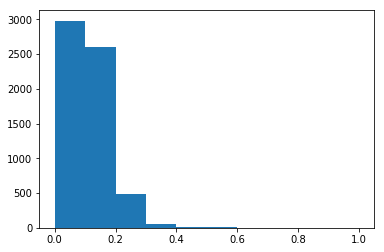

AUTHOR: EAP


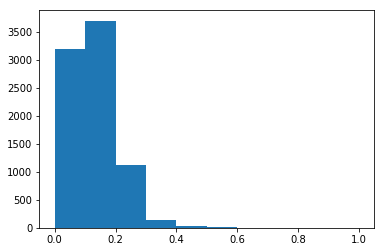

AUTHOR: HPL


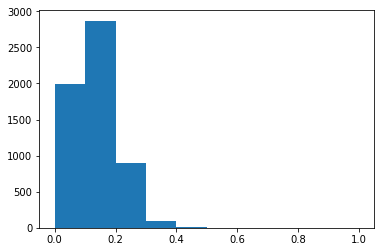

In [11]:
def iter_df_sent_adjadv_count(df):
    for _, row in df.iterrows():
        sentences = sent_tokenize(row['text'])
        for s in sentences:
            words = word_tokenize(s)
            adjadv = len([w for w, t in pos_tag(words) if t.startswith("RB") or t.startswith("JJ")])
            yield adjadv / len(words)
            
for author in classes:
    print("AUTHOR:", author)
    author_df = df[df['author'] == author]
    plt.hist(list(iter_df_sent_adjadv_count(author_df)), bins=10, range=(0, 1))
    plt.show()

## Phrasal Verbs

In [12]:
import re
import string

phrasal_verbs_grammar = """
phrasal:
    {<act%%> <up>}
    {<add%%> <.*>? <up>}
    {<ask%%> <around>}
    {<ask%%> <.*>? <out|over>}
    {<back%%> <.*>? <up>}
    {<back%%> <down|out|up>}
    {<bawl%%> <.*>? <out>}
    {<bear|bore|born> <down> <on>}
    {<bear|bore|born> <on|up|with>}
    {<blow|blew|blown> <.*>? <up>}
    {<blow|blew|blown> <in|over|up>}
    {<break|broke|broken> <.*>? <down|in|off|up>}
    {<break|broke|broken> <into|out>}
    {<bring|brought> <.*>? <about|along|around|away|back|down|in|off|on|out|over|to|up|forward|>}
    {<brush%%> <.*>? <off>}
    {<burn%%> <.*>? <down|up>}
    {<buy|bought> <.*>? <out|up>}
    {<buy|bought> <into>}
    {<call%%> <.*>? <off|up>}
    {<call%%> <for|on|upon>}
    {<calm%%> <.*>? <down>}
    {<care|cares|caring|cared> <for>}
    {<carry|carried|carries|carrying> <.*>? <out|over>}
    {<carry|carried|carries|carrying> <on>}
    {<catch|caught%%> <on|up>}
    {<check%%> <.*>? <off|out|over|through>}
    {<check%%> <back|by|in|into|on|out|with>}
    {<check%%> <up> <on>}
    {<cheer%%> <.*>? <up>}
    {<chip%%> <in>}
    {<chop%%> <.*>? <down|up>}
    {<clear%%> <out>}
    {<close|closing|closes|closed> <.*>? <down|up>}
    {<close|closing|closes|closed> <in> <on>}
    {<come|came|comes|coming> <about|across|along|away|by|down|in|into|off|on|out|over|round|through|up|with>}
    {<cope|coped|coping|copes> <with>}
    {<count%%> <.*>? <in|out|up>}
    {<count%%> <on>}
    {<crack%%> <down> <on>}
    {<crack%%> <up>}
    {<cross%%> <.*>? <out>}
    {<cut|cuts|cutten|cutting> <.*>? <off|out|up>}
    {<cut|cuts|cutten|cutting> <down|in>}
    {<deal|dealt|deals|dealing> <with>}
    {<die|dies|dying|died> <away|down|off|out>}
    {<disagree%%> <with>}
    {<do|done|did|doing|does> <.*>? <over>}
    {<do|done|did|doing|does> <away> <with>}
    {<do|done|did|doing|does> <without>}
    {<draw|drew|drawn|draws|drawing%%> <.*>? <up>}
    {<dress%%> <.*>? <down|up>}
    {<drive|drove|driven|driving|drives> <.*>? <back>}
    {<drop%%> <in|out|over>}
    {<drop%%> <.*>? <off>}
    {<eat|eats|ate|eaten|eats> <.*>? <up>}
    {<eat%%> <away|in|out|up>}
    {<face|faces|facing|faced> <up> <to>}
    {<fall|fell|falling|falls|fallen> <back> <on>}
    {<fall|fell|falling|falls|fallen> <apart|behind|off|through>}
    {<fall|fell|falling|falls|fallen> <out> <with>}
    {<feel|felt|feeling|feels> <.*>? <up>}
    {<fight|fought|fights|fighting> <back|on>}
    {<figure%%> <.*>? <up|out>}
    {<fill%%> <.*>? <out|up|in>}
    {<find|found|finding|finds|finding> <.*>? <out>}
    {<fix%%> <.*>? <up>}
    {<follow%%> <through>}
    {<follow%%> <up> <on>}
    {<get|got|gotten|gets|getting> <.*>? <across|back|off|on|out|up>}
    {<get|got|gotten|gets|getting> <ahead|along|around|away|by|in|into|over|through>}
    {<get|got|gotten|gets|getting> <back|down> <to>}
    {<get|got|gotten|gets|getting> <in|into|over|through>}
    {<give|gave|given|giving|gives> <off>}
    {<give|gave|given|giving|gives> <.*>? <back|out|up|away>}
    {<give|gave|given|giving|gives> <in>}
    {<go|went|gone|going|goes> <after|ahead|along|away|back|by|down|for|in|into|off|on|out|over|round|through|up|with|without>}
    {<grow|grew|grown|grows|growing> <under|up>}
    {<hand%%> <.*>? <back|down|in|out|over|up>}
    {<hang|hung|hanged|hanging|hangs> <around|out>}
    {<have|had|having|has> <.*>? <on|over>}
    {<hear%%> <from|of>}
    {<hit|hitting|hits> <on>}
    {<hold|held|holds|holding> <.*>? <back|off|up>}
    {<hold|held|holds|holding> <on|out>}
    {<hook%%> <.*>? <up>}
    {<iron%%> <.*>? <out>}
    {<jack%%> <up>}
    {<join%%> <in>}
    {<joke|jokes|joking|jokes|joked> <around>}
    {<jump%%> <in|to>}
    {<keep|kept|keeping|keeps> <.*>? <around|away|back|down|in|off|out|over|up>}    
    {<keep|kept|keeping|keeps> <at|on|to>}
    {<kick%%> <back|in>}
    {<knock%%> <over|out>}
    {<lay|laid|lays|laying> <.*>? <down|off|out>}
    {<lay|laid|lays|laying> <in> <on>}
    {<lay|laid|lays|laying> <into>}
    {<leave|left|leaves|leaving> <.*>? <out>}
    {<let|lets|letting> <.*>? <down|out>}
    {<let|lets|letting> <up>}
    {<lie%%> <down|with>}
    {<light%%> <.*>? <up>}
    {<live|lives|living|lived> <.*>? <down>}
    {<live|lives|living|lived> <on|with>}
    {<live|lives|living|lived> <up> <to>}
    {<look%%> <.*>? <over|up>}
    {<look%%> <after|around|back|down|for|forward|into|on|out|round|up>}
    {<look%%> <up> <to>}
    {<make|making|made|makes> <.*>? <out|over|up>}
    {<mix%%> <.*>? <up>}
    {<move|moves|moving|moved> <.*>? <back|in|out|up>}
    {<move|moves|moving|moved> <on>}
    {<name|names|naming|named> <.*>? <after>}
    {<nod|nodded|nods|nodding> <off>}
    {<nose|noses|nosed|nosing> <around>}
    {<occur%%> <to>}
    {<open%%> <up>}
    {<pan%%> <out>}
    {<pass%%> <.*>? <off|on|up|out>}
    {<pass%%> <away>}
    {<pay|paid|paying|pays> <.*>? <back|off>}
    {<pick%%> <.*>? <out|up>}
    {<pick%%> <on>}
    {<play%%> <.*>? <down|up>}
    {<point%%> <.*>? <out>}
    {<pull%%> <down|in|out|through>}
    {<put|puts|putting> <.*>? <across|away|back|down|in|off|on|out|up|forward|together>}
    {<quiet%%> <.*>? <down>}
    {<ring|rang|rung|ringing|rings> <.*>? <up>}
    {<rule|rulling|rules|ruled> <.*>? <out>}
    {<run|running|runs|ran> <.*>? <down|off>}
    {<run|running|runs|ran> <across|against|away|for|into|through>}
    {<run|running|runs|ran> <out> <of>}
    {<save%%> <.*>? <up>}
    {<screw%%> <.*>? <up>}
    {<see|saw|seen|seeing|sees> <.*>? <off|through>}
    {<see|saw|seen|seeing|sees> <about|to>}
    {<sell|sells|sold|selling> <.*>? <out>}
    {<set|sets|setting> <.*>? <down|off|out|up>}
    {<set|sets|setting> <about>}
    {<settle%%> <on|up>}
    {<show|shew|shown|shows"showing> <.*>? <off|up>}
    {<shut|shutting|shuts> <.*>? <off|up|down>}
    {<sign%%> <off>}
    {<sit|sat|sits|sitting> <back|down|up>}
    {<slow%%> <.*>? <down|up>}
    {<spell%%> <.*>? <out>}
    {<spend|spending|spends|spent> <away>}
    {<stand|stood|standing|stands> <.*>? <up>}
    {<stand|stood|standing|stands> <by|for|out>}
    {<stand|stood|standing|stands> <up> <to>}
    {<stay%%> <over>}
    {<stick|sticks|stuck|sticking> <it> <to>}
    {<stick|sticks|stuck|sticking> <to|with>}
    {<stick|sticks|stuck|sticking> <up> <for>}
    {<strip%%> <down|off>}
    {<take|took|taken|takes|taking> <.*>? <away|back|down|for|in|off|on|out|over|up>}
    {<take|took|taken|takes|taking> <after>}
    {<take|took|taken|takes|taking> <.*>? <over>}
    {<take|took|taken|takes|taking> <back>}
    {<tear|tore|torn|tearing|tears> <.*>? <down|down>}
    {<tell|told|telling|tells> <.*>? <off>}
    {<tell|told|telling|tells> <on>}
    {<think|thought|thinks|thinking> <.*>? <over|through|up>}
    {<throw|threw|thrown|throws|throwing> <.*>? <up|away|out>}
    {<tie|ties|tying|tied> <.*>? <up>}
    {<tire|tired|tiring> <.*>? <out>}
    {<touch%%> <.*>? <up>}
    {<touch%%> <on>}
    {<try|tries|tried|trying> <.*>? <on|out>}
    {<turn%%> <.*>? <around|away|back|down|off|out|over|up|in|on>}    
    {<turn%%> <into|round>}
    {<use%%> <.*>? <up>}
    {<veer%%> <away> <from>}
    {<wait%%> <on|up>}
    {<wake|woke|waken|waking|wakes> <.*>? <up>}
    {<wash%%> <.*>? <up>}
    {<watch%%> <out>}
    {<wear|wore|worn|wears|wearing> <.*>? <out|down>}
    {<wear|wore|worn|wears|wearing> <off>}
    {<wind%%> <.*>? <up>}
    {<wipe%%> <.*>? <out>}
    {<work%%> <out>}
    {<write%%> <.*>? <down|out|up>}
    {<yak%%> <on> <about>?}    
    {<yammer%%> <on> <about>?}
    {<zero%%> <in> <on>}
    {<zip%%> <around>}
    {<zone%%> <out>}
    {<zonk%%> <out>}
    {<zoom%%> <in>}
"""

phrasal_verbs_grammar = phrasal_verbs_grammar.replace("%%", "(ing|d|ed|ied|s|es|ies)?")
# print(phrasal_verbs_grammar)

PV_CHUNKER = RegexpParser(phrasal_verbs_grammar)
print(PV_CHUNKER.parse([('I', 'I'), ('was', 'was'), ('acting', 'acting'), ('up', 'up'), ('for', 'for'), ('nothing', 'nothing')]))
print(PV_CHUNKER.parse([('I', 'I'), ('was', 'was'), ('asking', 'asking'), ('over', 'over'), ('for', 'for'), ('nothing', 'nothing')]))
print(PV_CHUNKER.parse([('I', 'I'), ('wore', 'wore'), ('me', 'me'), ('down', 'down'), ('for', 'for'), ('nothing', 'nothing')]))
print(PV_CHUNKER.parse([('I', 'I'), ('used', 'used'), ('up', 'up'), ('down', 'down'), ('for', 'for'), ('nothing', 'nothing')]))

def phrasal_tokenizer(text):
    words = word_tokenize(text)
    doubled_words = [(w, w) for w in words]
    chunked_words = PV_CHUNKER.parse(doubled_words)
    chunks = [t for t in chunked_words if isinstance(t, Tree)]
    return [' '.join([w[0] for w in t]) for t in chunks]

print(phrasal_tokenizer("I went up and down on this street all day. My car was acting up again."))

(S I/I was/was (phrasal acting/acting up/up) for/for nothing/nothing)
(S
  I/I
  was/was
  (phrasal asking/asking over/over)
  for/for
  nothing/nothing)
(S I/I (phrasal wore/wore me/me down/down) for/for nothing/nothing)
(S I/I (phrasal used/used up/up) down/down for/for nothing/nothing)
['went up', 'acting up']


In [13]:
p7 = Pipeline([
    ('vectorizer', CountVectorizer(
        ngram_range=(1, 2), tokenizer=phrasal_tokenizer)),
    ('classifier', LogisticRegression()),
])

p7.fit(X_train, y_train)
print(p7.score(X_test, y_test))

0.409346271706


## Collocations

In [14]:
# Get the first 200 collocations in the text

entire_text = ""
# Build a laaaarge text
for t in X_train:
    entire_text += " " + t

# A list of all the words
words = word_tokenize(entire_text)
    
bigram_measures = nltk.collocations.BigramAssocMeasures()
trigram_measures = nltk.collocations.TrigramAssocMeasures()

bigram_finder = BigramCollocationFinder.from_words(words)
bigram_finder.apply_freq_filter(10)
top_bigrams = set(bigram_finder.nbest(bigram_measures.pmi, 3000))
print(top_bigrams)

trigram_finder = TrigramCollocationFinder.from_words(words)
trigram_finder.apply_freq_filter(8)
top_trigrams = set(trigram_finder.nbest(trigram_measures.pmi, 1500))
print(top_trigrams)

def collocations_tokenizer(text):
    words = word_tokenize(text)
    
    text_bigrams = set(bigrams(words))
    text_trigrams = set(trigrams(words))
    
    return ['__BIAS__'] + [' '.join(ng) for ng in (list(text_bigrams.intersection(top_bigrams)) + list(text_trigrams.intersection(top_trigrams)))]
    
print(collocations_tokenizer(entire_text[200000:300000]))



{('for', 'one'), ('Then', 'I'), ('can', 'you'), ('a', 'minute'), ('why', 'I'), ('few', 'words'), ('he', 'cried'), ('as', 'usual'), ('the', 'deck'), ('in', 'their'), ('said', 'Dupin'), ('how', 'much'), ('he', 'had'), ('no', 'longer'), ('the', 'most'), ('evidence', 'of'), ("''", 'We'), ('.', 'Those'), ('the', 'afternoon'), ('delight', '.'), ('the', 'tone'), ('was', 'suddenly'), ('there', 'were'), ('well', 'as'), ('of', 'love'), ('Street', '.'), ('of', 'the'), ('of', 'evil'), ('her', 'heart'), ('the', 'hut'), ('added', 'to'), ('very', 'little'), ('a', 'series'), ('I', 'tell'), ('the', 'table'), ('be', 'understood'), ('the', 'centre'), ('you', 'shall'), ('any', 'thing'), ('nothing', 'more'), ('were', 'now'), ('off', 'his'), ('as', 'possible'), ('of', 'humanity'), ('a', 'distant'), ('a', 'chance'), ('could', 'no'), ('I', 'found'), ('but', 'when'), ('the', 'second'), ('for', 'any'), ('as', 'a'), ('not', 'quite'), ('``', 'We'), ('little', 'more'), ('destruction', '.'), ('we', 'will'), ('had',

{('the', 'necessity', 'of'), ('me', '.', 'The'), ('the', 'forest', ','), ('an', 'angle', 'of'), ('seemed', 'to', 'be'), ('my', 'father', ','), ('we', 'could', 'not'), ('I', 'have', 'already'), ('of', 'a', 'young'), ('I', 'had', 'so'), ('the', 'day', 'before'), ('the', 'sides', 'of'), ('distance', 'from', 'the'), ('it', 'to', 'be'), ('neck', ',', 'and'), ('that', 'there', 'was'), ('corner', 'of', 'the'), ('.', 'As', 'we'), ('.', 'Indeed', ','), ('of', 'the', 'car'), ('is', 'to', 'say'), ('what', 'I', 'saw'), ('He', 'was', 'a'), (',', 'according', 'to'), ('rest', 'of', 'the'), ('in', 'the', 'ancient'), ('.', "''", 'I'), ('.', '``', 'Do'), ('middle', 'of', 'the'), ('I', 'continued', 'my'), ('the', 'influence', 'of'), ('do', 'not', 'know'), ('a', 'few', 'words'), ('in', 'a', 'very'), ('the', 'bottom', 'of'), ('It', 'will', 'be'), (',', "''", 'replied'), ('.', 'That', 'night'), ('I', 'heard', 'the'), ('I', 'was', 'about'), ('the', 'rear', 'of'), ('him', '.', '``'), ('end', 'of', 'the'), ('o

In [15]:
phrasal_collocation_pipeline = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
            ('text_features', Pipeline([
                ('ngram_vectorizer', CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize))
            ])),
            ('phrasal_verbs_features', Pipeline([
                ('pv_vectorizer', CountVectorizer(tokenizer=phrasal_tokenizer))
            ])),
            ('collocations_features', Pipeline([
                ('collocation_vectorizer', CountVectorizer(tokenizer=collocations_tokenizer))
            ])),
        ]
    )),
    ('classifier', LogisticRegression())
])

phrasal_collocation_pipeline.fit(X_train, y_train)
print(phrasal_collocation_pipeline.score(X_test, y_test))

0.833503575077


In [ ]:
# # pipeline2 = Pipeline([
# #     ('features', FeatureUnion(
# #         transformer_list=[
# #             ('text_features', Pipeline([
# #                 ('ngram_vectorizer', HashingVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize))
# #             ])),
# #             ('phrasal_verbs_features', Pipeline([
# #                 ('pv_vectorizer', HashingVectorizer(tokenizer=phrasal_tokenizer))
# #             ])),
# #             ('collocations_features', Pipeline([
# #                 ('collocation_vectorizer', HashingVectorizer(tokenizer=collocations_tokenizer))
# #             ])),
# #         ]
# #     )),
# #     ('regressor', Perceptron(verbose=True, max_iter=20, tol=0.00001))
# # ])

# feature_extractor = FeatureUnion(
#     transformer_list=[
#         ('text_features', Pipeline([
#             ('ngram_vectorizer', HashingVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize))
#         ])),
#         ('phrasal_verbs_features', Pipeline([
#             ('pv_vectorizer', HashingVectorizer(tokenizer=phrasal_tokenizer))
#         ])),
#         ('collocations_features', Pipeline([
#             ('collocation_vectorizer', HashingVectorizer(tokenizer=collocations_tokenizer))
#         ])),
#     ]
# )
# model = Perceptron(max_iter=20, tol=0.00001)

# for i in range(10):
#     print("Iteration %s" % i)
#     current_batch, batch_sz = 0, 500
#     while True:
#         print("Minibatch - ", current_batch)
#         X_batch = X_train[current_batch * batch_sz:(current_batch + 1) * batch_sz]
#         y_batch = y_train[current_batch * batch_sz:(current_batch + 1) * batch_sz]
        
#         if X_batch.empty:
#             break

#         X_train_features = feature_extractor.transform(X_batch)
#         model.partial_fit(X_train_features, y_batch, classes=list(classes))
        
#         current_batch += 1
    
# print(model.score(feature_extractor.transform(X_test), y_test))

In [16]:
pipeline_bayes = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
            ('text_features', Pipeline([
                ('ngram_vectorizer', CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize))
            ])),
#             ('phrasal_verbs_features', Pipeline([
#                 ('pv_vectorizer', CountVectorizer(tokenizer=phrasal_tokenizer))
#             ])),
#             ('collocations_features', Pipeline([
#                 ('collocation_vectorizer', CountVectorizer(tokenizer=collocations_tokenizer))
#             ])),
        ]
    )),
    ('classifier', MultinomialNB(alpha=.1))
])

pipeline_bayes.fit(X_train, y_train)
print(pipeline_bayes.score(X_test, y_test))

0.865934627171


In [18]:
pipeline_bbayes = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
            ('text_features', Pipeline([
                ('ngram_vectorizer', CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize))
            ])),
#             ('phrasal_verbs_features', Pipeline([
#                 ('pv_vectorizer', CountVectorizer(tokenizer=phrasal_tokenizer))
#             ])),
#             ('collocations_features', Pipeline([
#                 ('collocation_vectorizer', CountVectorizer(tokenizer=collocations_tokenizer))
#             ])),
        ]
    )),
    ('classifier', BernoulliNB(alpha=.1))
])

pipeline_bbayes.fit(X_train, y_train)
print(pipeline_bbayes.score(X_test, y_test))
# 0.873340143003
# 0.873340143003 with phrasal_verbs_features
# 0.871807967314 with collocations_features


0.867211440245


In [19]:
pipeline_pac = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
            ('text_features', Pipeline([
                ('ngram_vectorizer', CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize))
            ])),
            ('phrasal_verbs_features', Pipeline([
                ('pv_vectorizer', CountVectorizer(tokenizer=phrasal_tokenizer))
            ])),
            ('collocations_features', Pipeline([
                ('collocation_vectorizer', CountVectorizer(tokenizer=collocations_tokenizer))
            ])),
        ]
    )),
    ('classifier', PassiveAggressiveClassifier(max_iter=50))
])

pipeline_pac.fit(X_train, y_train)
print(pipeline_pac.score(X_test, y_test))
# 0.833503575077 Using all features


0.829673135853


In [22]:
pipeline_topics = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
            ('topics', Pipeline([
                ('count_vectorizer', CountVectorizer(max_df=0.95, min_df=2, stop_words='english')),
                ('lda', LatentDirichletAllocation(n_components=100, max_iter=5, learning_method='online', learning_offset=50.))
            ])),
            ('text_features', Pipeline([
                ('ngram_vectorizer', CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize))
            ])),
        ]
    )),    
    ('classifier', LogisticRegression())
])

pipeline_topics.fit(X_train, y_train)
print(pipeline_topics.score(X_test, y_test))

0.83682328907


In [24]:
from nltk import stem
stemmer = stem.PorterStemmer()

def stemming_tokenizer(text):
    return [stemmer.stem(t) for t in word_tokenize(text)]

pipeline_bbayes_with_stemming = Pipeline([
    ('features', FeatureUnion(
        transformer_list=[
            ('text_features', Pipeline([
                ('ngram_vectorizer', CountVectorizer(ngram_range=(1, 2), tokenizer=stemming_tokenizer, 
                                                     binary=True, min_df=2, max_df=0.9, stop_words='english'))
            ])),
        ]
    )),
    ('classifier', BernoulliNB(alpha=.1))
])

pipeline_bbayes_with_stemming.fit(X_train, y_train)
print(pipeline_bbayes_with_stemming.score(X_test, y_test))
# binary=True 0.870275791624


0.827630234934


In [ ]:
# pipeline_nn = Pipeline([
#     ('features', FeatureUnion(
#         transformer_list=[
#             ('text_features', Pipeline([
#                 ('ngram_vectorizer', CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize, 
#                                                      binary=True, min_df=2, max_df=0.9))
#             ])),
#             ('topics', Pipeline([
#                 ('count_vectorizer', CountVectorizer(max_df=0.95, min_df=2, stop_words='english')),
#                 ('lda', LatentDirichletAllocation(n_components=20, max_iter=5, learning_method='online', learning_offset=50.))
#             ])),
#         ]
#     )),
#     ('classifier', MLPClassifier(solver='sgd', activation='relu', 
#                                  hidden_layer_sizes=(5000, ), verbose=True, learning_rate='adaptive',
#                                  learning_rate_init=.01))
# ])

# pipeline_nn.fit(X_train, y_train)
# print(pipeline_nn.score(X_test, y_test))
# # hidden_layer_sizes=(100, ) 0.85
# # hidden_layer_sizes=(200, ) 0.856741573034
# # hidden_layer_sizes=(500, ) 0.855975485189
# # hidden_layer_sizes=(200, 50) 0.849846782431
# # hidden_layer_sizes=(200, 100) 0.858273748723
# # solver='sgd', activation='relu', 
# #                                  hidden_layer_sizes=(200, 100), verbose=True, learning_rate='adaptive',
# #                                  learning_rate_init=.001  0.849846782431 

In [48]:
# from xgboost import XGBClassifier
# from sklearn.preprocessing import LabelEncoder

# label_encoder = LabelEncoder()
# label_encoder = label_encoder.fit(y_train)
# encoded_y_train = label_encoder.transform(y_train)
# class CSCTransformer(TransformerMixin):
#     def transform(self, X, y=None, **fit_params):
#         return X.tocsc()

#     def fit_transform(self, X, y=None, **fit_params):
#         self.fit(X, y, **fit_params)
#         return self.transform(X)

#     def fit(self, X, y=None, **fit_params):
#         return self

#     def get_params(self, deep=True):
#         return {}
    
# pipeline_xgb = Pipeline([
#     ('features', FeatureUnion(
#         transformer_list=[
#             ('text_features', Pipeline([
#                 ('ngram_vectorizer', CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize, 
#                                                      binary=True, min_df=2, max_df=0.9))
#             ])),
#         ]
#     )),
#     ('transformer', CSCTransformer()),
#     ('classifier', XGBClassifier(nthread=4, max_depth=2, n_estimators=20000, learning_rate=0.1, 
#                                  colsample_bytree=0.5, subsample=0.3,
#                                  colsample_bylevel=0.5,)),
# ])

# pipeline_xgb.fit(X_train, y_train)

# encoded_y_test = label_encoder.transform(y_test)
# print(pipeline_xgb.score(X_test, y_test))

# #   0.757660878447  ('classifier', XGBClassifier(max_depth=50, n_estimators=200, learning_rate=0.05, )),
# # 0.816138917263 (nthread=4, max_depth=10, n_estimators=4000, learning_rate=0.1, 
# #                                  colsample_bytree=0.7,
# #                                  colsample_bylevel=0.6,)),
# # 0.822522982635 (nthread=4, max_depth=3, n_estimators=4000, learning_rate=0.1, 
# #                                  colsample_bytree=0.7,
# #                                  colsample_bylevel=0.6,)),
# # 0.829673135853 (nthread=4, max_depth=3, n_estimators=8000, learning_rate=0.1, 
# #                                  colsample_bytree=0.7,
# #                                  colsample_bylevel=0.6,))
# # 0.82277834525 (nthread=4, max_depth=3, n_estimators=20000, learning_rate=0.1, 
# #                                  colsample_bytree=0.7,
# #                                  colsample_bylevel=0.6,)
# # 0.799540347293 (nthread=4, max_depth=2, n_estimators=20000, learning_rate=0.1, 
# #                                  colsample_bytree=0.5, subsample=0.3,
# #                                  colsample_bylevel=0.5,)

0.799540347293


In [28]:
voting_classifier = VotingClassifier(estimators=[
#     ('p1', p1),
#     ('p2', p2),
#     ('p7', p7),
    ('phrasal_collocation_pipeline', phrasal_collocation_pipeline),
    ('pipeline_bayes', pipeline_bayes),
    ('pipeline_bbayes', pipeline_bbayes),
#     ('pipeline_pac', pipeline_pac),
    ('pipeline_topics', pipeline_topics),
    ('pipeline_bbayes_with_stemming', pipeline_bbayes_with_stemming)
])

voting_classifier.fit(X_train, y_train)
print(voting_classifier.score(X_test, y_test))

0.877936670072


In [54]:
soft_voting_classifier = VotingClassifier(estimators=[
#     ('p1', p1),
#     ('p2', p2),
#     ('p7', p7),
    ('phrasal_collocation_pipeline', phrasal_collocation_pipeline),
    ('pipeline_bayes', pipeline_bayes),
    ('pipeline_bbayes', pipeline_bbayes),
#     ('pipeline_pac', pipeline_pac),
    ('pipeline_topics', pipeline_topics),
    ('pipeline_bbayes_with_stemming', pipeline_bbayes_with_stemming)
], voting='soft')

soft_voting_classifier.fit(X_train.append(X_test), y_train.append(y_test))
print(soft_voting_classifier.score(X_test, y_test))

0.996424923391


In [51]:

vectorizer = CountVectorizer(ngram_range=(1, 2), tokenizer=word_tokenize)
vectorizer.fit(X_train)
bagging_classifier = BaggingClassifier(BernoulliNB(alpha=.1),
                                       max_samples=0.85, max_features=0.85, n_estimators=500)

bagging_classifier.fit(vectorizer.transform(X_train), y_train)
print(bagging_classifier.score(vectorizer.transform(X_test), y_test))



0.864913176711


In [55]:
tdf = pd.read_csv('data/test.csv')

predictor = soft_voting_classifier

for c in predictor.classes_:
    tdf[c] = None

prob_predictions = predictor.predict_proba(tdf['text'])
for c in predictor.classes_:
    tdf[c] = [round(p[list(predictor.classes_).index(c)], 6) for p in prob_predictions]
tdf = tdf.drop('text', axis=1)
tdf.to_csv('data/test_result4.csv', index=False)
tdf

,id,EAP,HPL,MWS
0,id02310,0.020325,0.003221,0.976454
1,id24541,0.989206,0.010794,0.000000
2,id00134,0.002188,0.972282,0.025530
3,id27757,0.972631,0.024483,0.002886
4,id04081,0.822765,0.045661,0.131574
5,id27337,0.994196,0.001034,0.004770
6,id24265,0.891910,0.107252,0.000838
7,id25917,0.000545,0.084688,0.914767
8,id04951,0.999381,0.000449,0.000170
9,id14549,0.973091,0.003742,0.023167


In [36]:
tdf = pd.read_csv('data/test.csv')

predictor = voting_classifier

for c in predictor.classes_:
    tdf[c] = None
encoder = LabelBinarizer()
encoder.classes_ = predictor.classes_
prob_predictions = encoder.transform(predictor.predict(tdf['text']))
print(prob_predictions)
for c in predictor.classes_:
    tdf[c] = [round(p[list(predictor.classes_).index(c)], 6) for p in prob_predictions]
tdf = tdf.drop('text', axis=1)
tdf.to_csv('data/test_result2.csv', index=False)
tdf

[[0 0 1]
 [1 0 0]
 [0 1 0]
 ..., 
 [1 0 0]
 [0 0 1]
 [0 1 0]]


,id,EAP,HPL,MWS
0,id02310,0,0,1
1,id24541,1,0,0
2,id00134,0,1,0
3,id27757,1,0,0
4,id04081,1,0,0
5,id27337,1,0,0
6,id24265,1,0,0
7,id25917,0,0,1
8,id04951,1,0,0
9,id14549,1,0,0
